In [1]:
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pickle
import numpy as np
import torch.nn.functional as F
import nltk
import torch
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import nn

In [2]:
german_stop_words = stopwords.words('german')
german_stop_words.append("fur")

In [3]:
# CONSTANTS
DATA_PATH = "D:/10kgerdataset/"
TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"
CLASS_TO_IDX = {
    "etat": 0,
    "inland": 1,
    "international": 2,
    "kultur": 3,
    "panorama": 4,
    "sport": 5,
    "web": 6,
    "wirtschaft": 7,
    "wissenschaft": 8
}
plt.style.use("dark_background")

In [4]:
try:
    df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_CSV))
    df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_CSV))
except FileNotFoundError:
    print("File was not found at specific location.")
    raise

In [5]:
def remove_punctuation(document: str) -> str:
    return re.sub(r'[^\w\s]', '', document)

def remove_numbers(document: str) -> str:
    return re.sub(r'$\d+\W+|\b\d+\b|\W+\d+$', '', document)

def map_umlaut(document: str) -> str:
    umlaut_mapping = {
        "ß": "b",
        "ü": "u",
        "ä": "a",
        "ö": "o",
        "ë": "e",
    }
    for k, v in umlaut_mapping.items():
        document = document.replace(k, v)
    return document

def stop_word_removal(document: str) -> str:
    return " ".join(w for w in document.split() if w not in german_stop_words)

def save_vocab(vocab, path):
    output = open(path, 'wb')
    pickle.dump(vocab, output)
    output.close()

def load_vocab(path):
    output = open(path, 'rb')
    vocabulary = pickle.load(output)
    output.close
    return vocabulary

In [6]:
vocab = load_vocab("vocabulary")

In [7]:
def run_pre_processing_pipeline(df, tokenize: bool):
    new_df = df.copy(deep=False)
    
    new_df["text"] = new_df["text"].str.lower()
    new_df["label"] = new_df["label"].str.lower()
    
    new_df = new_df.dropna()
    
    new_df["text"] = new_df["text"].apply(remove_punctuation)
    new_df["text"] = new_df["text"].apply(remove_numbers)
    new_df["text"] = new_df["text"].apply(map_umlaut)
    new_df["text"] = new_df["text"].apply(stop_word_removal)
    
    if tokenize:
        new_df["text"] = new_df["text"].apply(lambda x: x.split())
        new_df["text"] = new_df["text"].apply(lambda x: vocab(x))
        new_df["label"] = new_df["label"].apply(lambda x: CLASS_TO_IDX[x])
    return new_df

In [8]:
class GnadDataset(Dataset):
    def __init__(self, df):
        try:
            data = run_pre_processing_pipeline(df, True)
            self.x = np.array(data["text"])
            self.y = torch.stack([torch.tensor(label) for label in data["label"]])
        except Exception:
            raise
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [9]:
train_dataset = GnadDataset(df_train)
test_dataset = GnadDataset(df_test)

In [10]:
def collate_wrapper(batch):
    batch = list(zip(*batch))
    max_length = max(len(arr) for arr in batch[0])
    
    inp = torch.stack([F.pad(torch.tensor(arr), (0, max_length - len(arr))) for arr in batch[0]])
    tgt = torch.stack(batch[1])
    seq_lengths = torch.stack([torch.tensor(len(arr)) for arr in batch[0]])
    return inp, tgt, seq_lengths

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_wrapper)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_wrapper)

In [12]:
class Model(nn.Module):
    def __init__(self, vocab_size, e_dim, h_dim, num_layer, output_dim, is_bidirectional: bool = True):
        super().__init__()
        self.h_dim = h_dim
        self.directions = 2 if is_bidirectional else 1
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=e_dim, padding_idx=0)
        self.lstm_layer = nn.LSTM(input_size=e_dim,
                                hidden_size=h_dim,
                                num_layers=num_layer,
                                batch_first=True,
                                bidirectional=True)
        self.fc_1 = nn.Linear(h_dim * 2, h_dim)
        self.fc_2 = nn.Linear(h_dim, output_dim)
        self.dropout = nn.Dropout(p=.3)
        
    def forward(self, x, seq_lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(input=x, lengths=seq_lengths, batch_first=True, enforce_sorted=False)
        _, (h_state, c_state) = self.lstm_layer(x)
        
        # The outputs of the two directions of the LSTM are concatenated on the last dimension
        x = torch.cat((h_state[-2, :, :], h_state[-1, :, :]), dim=1)
        x = self.dropout(F.gelu(self.fc_1(x)))
        x = self.fc_2(x)
        
        return x
        

In [13]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(vocab_size=len(vocab), e_dim=64, h_dim=128, num_layer=2, output_dim=10)
model = model.to(device=device)
model.train()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
num_epochs = 32
EARLY_STOPPING_TOLERANCE = 4

In [14]:
import datetime
cost_values = []
accuracy_values = []

min_cost = 10000.0
counter = 0
for epoch in range(num_epochs):
        total_cost = 0.0
        accuracy = 0
        
        for i, (data, labels, seq_lengths) in enumerate(train_dataloader):
            model.zero_grad(set_to_none=True)
            data = data.to(device=device)
            labels = labels.to(device=device)

            outputs = model(data, seq_lengths)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            predicted_categories = torch.argmax(outputs, dim=1)
            accuracy_tensor = torch.sum(labels == predicted_categories)
            accuracy += accuracy_tensor.item()
            total_cost += loss.item() / len(train_dataloader)

        cost_values.append(total_cost)
        accuracy_values.append(accuracy / len(train_dataset))
        
        if total_cost > min_cost:
            counter += 1
            print("cost did not change at epoch: ", epoch, " total epoch stagnation: ", counter)
#             training_logger.log_info(f"Cost did not decrease at epoch: {epoch}, total epoch stagnation {counter}")
        elif total_cost < min_cost:
            min_cost = total_cost
            counter = 0
            print("minimum cost currently is: ", min_cost)
#             training_logger.log_info(f'The minimum cost currently is: {min_cost}.')

#         training_logger.log_info('{} Epoch {}, Training loss {}, Training Accuracy {}'.format(datetime.datetime.now(),
#                                                                                               epoch, total_cost,
#                                                                                               accuracy / len(dataset)))
        print('{} Epoch {}, Training loss {}, Training Accuracy {}'.format(datetime.datetime.now(),
                                                                           epoch, total_cost,
                                                                           accuracy / len(train_dataset)))
        if counter == EARLY_STOPPING_TOLERANCE:
            print("Stopping training due to over fitting...")
            break

minimum cost currently is:  2.1389794943397615
2021-11-14 20:38:39.520905 Epoch 0, Training loss 2.1389794943397615, Training Accuracy 0.1701350857977364
minimum cost currently is:  1.7339717629818607
2021-11-14 20:38:59.996976 Epoch 1, Training loss 1.7339717629818607, Training Accuracy 0.377023244493124
minimum cost currently is:  0.9328492617792656
2021-11-14 20:39:20.010611 Epoch 2, Training loss 0.9328492617792656, Training Accuracy 0.6820007301935013
minimum cost currently is:  0.44254055065519604
2021-11-14 20:39:40.082982 Epoch 3, Training loss 0.44254055065519604, Training Accuracy 0.8566386759157844
minimum cost currently is:  0.21766944056384063
2021-11-14 20:40:00.791854 Epoch 4, Training loss 0.21766944056384063, Training Accuracy 0.930753316295485
minimum cost currently is:  0.12898445553200658
2021-11-14 20:40:21.392684 Epoch 5, Training loss 0.12898445553200658, Training Accuracy 0.957770475842765
minimum cost currently is:  0.09079968015045463
2021-11-14 20:40:41.78333

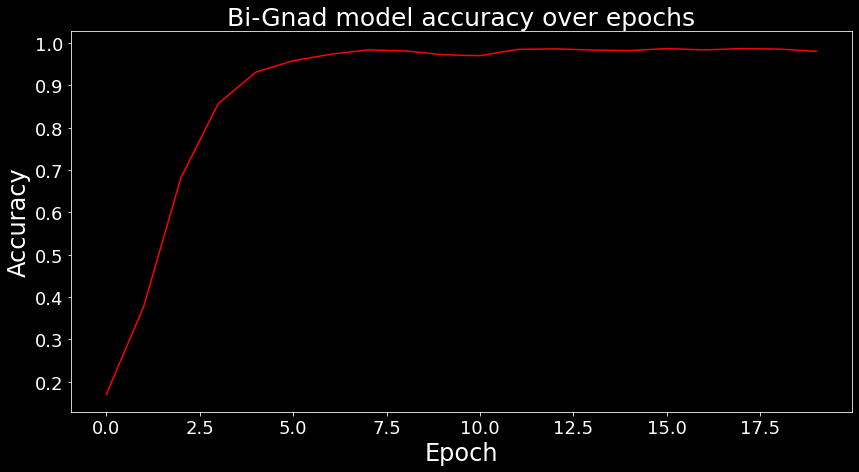

In [15]:
fig_dims = (14, 7)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Bi-Gnad model accuracy over epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Accuracy', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
_plt = plt.plot(accuracy_values, 'r')

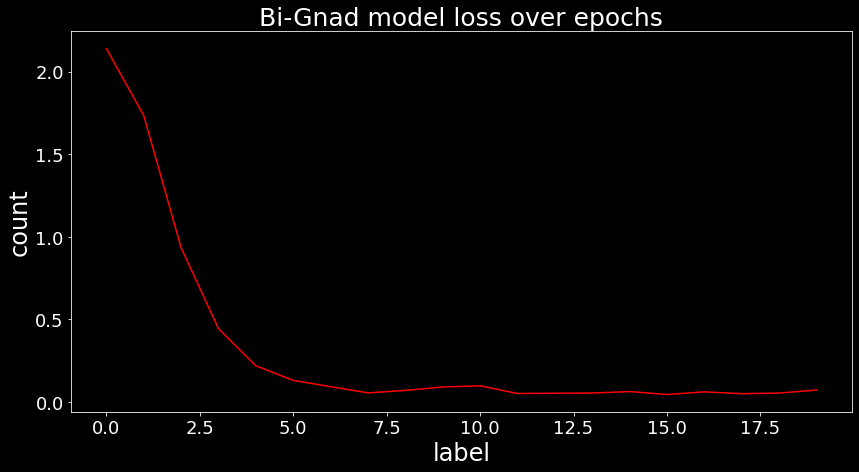

In [16]:
fig_dims = (14, 7)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Bi-Gnad model loss over epochs', fontsize=25)
plt.xlabel('label', fontsize=24)
plt.ylabel('count', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
_plt = plt.plot(cost_values, 'r')

In [17]:
model.eval()

Model(
  (embedding_layer): Embedding(186366, 64, padding_idx=0)
  (lstm_layer): LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc_1): Linear(in_features=256, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [18]:
accuracy = 0.0
with torch.no_grad():
    for i, (data, labels, seq_lengths) in enumerate(test_dataloader):
        data = data.to(device=device)
        labels = labels.to(device=device)
        outputs = model(data, seq_lengths)
        predicted_categories = torch.argmax(outputs, dim=1)
        accuracy_tensor = torch.sum(labels == predicted_categories)
        accuracy += accuracy_tensor.item()
        
print(f"Accuracy is: {accuracy / len(test_dataset)}")
        

Accuracy is: 0.6736381322957199


In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix    

In [20]:
y_pred = []
y_true = []
with torch.no_grad():
    for i, (data, labels, seq_lengths) in enumerate(test_dataloader):
        data = data.to(device=device)
        labels = labels.to(device=device)
        outputs = model(data, seq_lengths)
        predicted_categories = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted_categories.cpu().numpy())

<AxesSubplot:title={'center':'Classification report for Bi-Gnad model on the test set.'}>

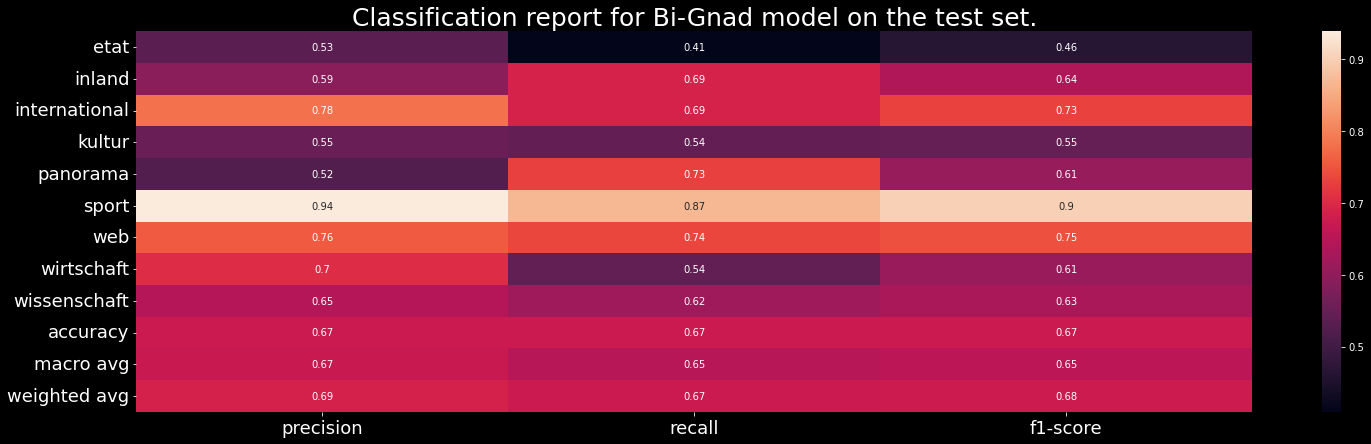

In [21]:
clf_report = classification_report(y_true, y_pred, target_names=CLASS_TO_IDX.keys(), output_dict=True)
plt.style.use("dark_background")
fig_dims = (25, 7)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Classification report for Bi-Gnad model on the test set.', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

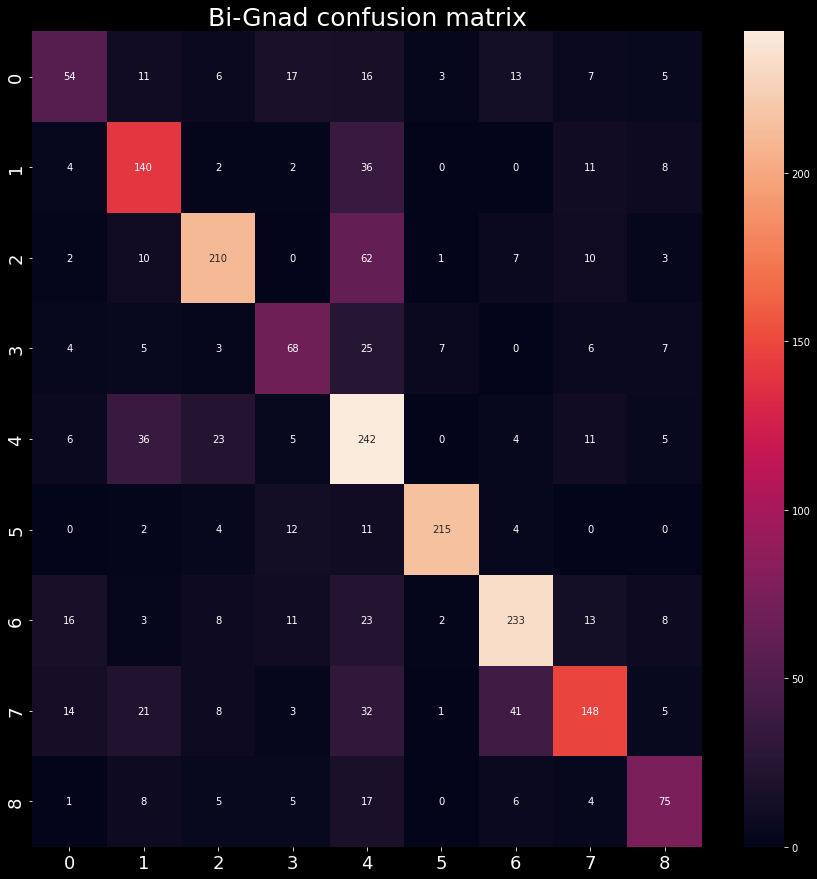

In [23]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Bi-Gnad confusion matrix', fontsize=25)
plt.xlabel('label', fontsize=24)
plt.ylabel('count', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')